<a href="https://colab.research.google.com/github/sim-so/HandsOnML/blob/main/04_Training_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. 모델 훈련 연습문제

## 12. 사이킷런 없이 소프트맥스 회귀 구현하기
- 조기 종료 사용
- 배치 경사하강법 이용

In [ ]:
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

### 랜덤 시드 고정

In [ ]:
np.random.seed(27)
random.seed(27)

### 샘플 데이터 불러오기 : Iris

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()

X = iris["data"]
y = iris["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=27, shuffle=True)

In [ ]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((120, 4), (30, 4), (120,), (30,))

### 소프트맥스 회귀 구현

In [ ]:
class SoftmaxRegression():
    def __init__(self, n_classes=3, learning_rate=0.1, n_iterations=1000, early_stopping=False, tol=1e-8, n_iter_no_change=10):
        super().__init__()
        self.n_classes = n_classes                          # the number of classes
        self.learning_rate=learning_rate                
        self.n_iterations=n_iterations                      # training iterations
        self.early_stopping = early_stopping                # Training will be stopped early if it is True and
        self.tol = tol                                      # if best_loss - validation_loss < tol
        self.n_iter_no_change = n_iter_no_change            # for several times as n_iter_no_change

    def fit(self, X, y, validation_set=None, verbosity=1):
        self.n_features = X.shape[1]                                        # input shape
        self.m = X.shape[0]                                                 # input amount
        self.theta = np.random.randn(self.n_features, self.n_classes)       # initial weights
        y_train = self._process_y(y)                                        # one-hot encoding for y

        if validation_set is not None:
            X_val, y_val = validation_set
            y_val = self._process_y(y_val)

        best_loss = np.infty
        count_iter_no_change = 0

        for i in range(self.n_iterations):
            train_prob = self._forward(X)                                   # softmax function
            gradients = 1/self.m * X.T.dot(train_prob - y_train)
            self.theta = self.theta - self.learning_rate * gradients

            if validation_set is None:
                continue

            val_prob = self._forward(X_val)
            val_loss = self._compute_loss(val_prob, y_val)
            if verbosity >= 1 and (i+1) % (self.n_iterations/verbosity) == 0:
                train_loss = self._compute_loss(train_prob, y_train)
                print(f"[{i+1}th iter] Train loss : {train_loss} / Validation loss : {val_loss}")
            if self.early_stopping is True:
                if best_loss - val_loss < self.tol:
                    count_iter_no_change += 1
                else:
                    best_loss = min(best_loss, val_loss)
                    count_iter_no_change = 0
                if count_iter_no_change >= self.n_iter_no_change:
                    print(f"Early stopped > Best iteration : {i+1} / Validation loss : {val_loss}")
                    break
    
    # softmax function
    def _forward(self, X):                                                  
        logits = X.dot(self.theta)                                          
        scores = np.exp(logits)
        prob = scores / np.sum(scores, axis=1, keepdims=True)
        return prob

    # predict a class
    def predict(self, X):
        prob = self._forward(X)
        pred = np.argmax(prob, axis=1)
        return pred

    # predict a probability for each class
    def predict_proba(self, X):
        prob = self._forward(X)
        return prob

    # assert y, one hot encoding 
    def _process_y(self, y):
        if y.ndim == 1:
            y_one_hot = self._to_one_hot(y)
            return y_one_hot
        elif y.ndim == 2 and y.shape[1] == self.n_classes:
            assert y.shape[1] == self.n_class, f"Class number not matched. target: {y.shape} / n_classes: {self.n_classes}"
            return y
        else:
            ValueError(f"Input shapes not matched. target: {y.shape} / input: {X.shape}, n_classes: {self.n_classes}")

    # one hot encoding
    def _to_one_hot(self, y):
        n_samples = y.shape[0]
        y_one_hot = np.zeros((n_samples, self.n_classes))
        y_one_hot[np.arange(n_samples), y] = 1
        return y_one_hot

    # cross entropy
    def _compute_loss(self, prob, y):
        epsilon = 1e-7
        loss = -np.mean(np.sum(y * np.log(prob + epsilon), axis=1))
        return loss

### 모델 훈련
실제로 훈련을 하다 보면 loss가 0.5~6인 상태에서 수십 iteration만에 조기 종료되는 경우도 있습니다.\
초기 theta 값이 모델 훈련에 영향을 크게 주기도 하고, 훈련 데이터가 작기 때문일 수도 있습니다.

In [ ]:
model = SoftmaxRegression(n_classes=3, n_iterations=10000, early_stopping=True)

In [ ]:
model.fit(X_train, y_train, validation_set=(X_val, y_val), verbosity=20)

[500th iter] Train loss : 0.17611682604454199 / Validation loss : 0.18614925710998717
[1000th iter] Train loss : 0.13187149176429347 / Validation loss : 0.1366866323808436
[1500th iter] Train loss : 0.11426421258945481 / Validation loss : 0.11788741498129124
[2000th iter] Train loss : 0.10450804889986703 / Validation loss : 0.10827681660105701
[2500th iter] Train loss : 0.09821164769390724 / Validation loss : 0.10273216776843057
[3000th iter] Train loss : 0.09377495541804234 / Validation loss : 0.09935705823455726
[3500th iter] Train loss : 0.09046501133902099 / Validation loss : 0.09727218752019166
[4000th iter] Train loss : 0.08789475586884979 / Validation loss : 0.09600963775288972
[4500th iter] Train loss : 0.08583884993839623 / Validation loss : 0.09529623626008583
[5000th iter] Train loss : 0.08415641566308013 / Validation loss : 0.09496160995015658
Early stopped > Best iteration : 5408 / Validation loss : 0.09489032492716767


### 모델 훈련 결과 확인
validation set에서는 30개 샘플 중 2개가 오분류 되었고,\
전체 iris 데이터에 대해서는 96.7%의 정확도를 보였습니다.

In [ ]:
model.predict(X_val)

array([2, 0, 2, 2, 1, 1, 1, 2, 1, 0, 1, 1, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0,
       1, 0, 2, 2, 1, 0, 1, 2])

In [ ]:
y_val

array([2, 0, 2, 2, 1, 1, 1, 2, 1, 0, 1, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 0,
       1, 0, 2, 2, 1, 0, 2, 2])

In [ ]:
y_pred = model.predict(X)
correct = sum(y == y_pred)
accuracy = correct / y.shape[0]
print(accuracy)

0.9666666666666667


### Visualization
2가지 변수 Petal length, Petal width에 따른 분류 결과를 2차원으로 시각화합니다.\
모델 학습 시에는 모든 변수(4개)를 사용하여 학습했기 때문에,\
경계선을 표현하기 위한 new 샘플의 나머지 2개 변수는 훈련 세트의 평균값으로 두었습니다.

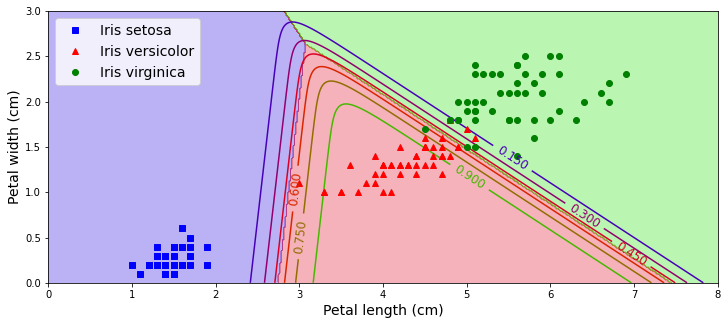

In [ ]:
x2, x3 = np.meshgrid(
    np.linspace(0, 8, 500).reshape(-1, 1),
    np.linspace(0, 3, 200).reshape(-1, 1)
)
x0_mean, x1_mean, _, _ = np.mean(X_train, axis=0)
X_new = np.c_[x2.ravel(), x3.ravel()]
X_mean = np.full_like(X_new, [x0_mean, x1_mean])
X_new = np.concatenate([X_mean, X_new], axis=1)
y_new_prob = model.predict_proba(X_new)
y_new_pred = model.predict(X_new)
zz = y_new_pred.reshape(x2.shape)
zz1 = y_new_prob[:, 1].reshape(x2.shape)

plt.figure(figsize=(12, 5))
plt.plot(X[y==0, 2], X[y==0, 3], "bs", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "r^", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "go", label="Iris virginica")

plt.contourf(x2, x3, zz, cmap=plt.cm.brg, alpha=0.3)
contour = plt.contour(x2, x3, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length (cm)", fontsize=14)
plt.ylabel("Petal width (cm)", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.show()